<a href="https://colab.research.google.com/github/shashigew/Big-Data-Project/blob/main/Country_Wise_Medal_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install pyspark

In [17]:
from google.colab import files
uploaded = files.upload()  # Upload dictionary.csv, summer.csv, winter.csv

Saving dictionary.csv to dictionary.csv
Saving summer.csv to summer.csv
Saving winter.csv to winter.csv


In [18]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, sum as spark_sum, avg, when, lit, year, desc, round
from pyspark.sql.types import StringType, IntegerType, DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd  # For final viz

# Initialize Spark
spark = SparkSession.builder.appName("OlympicAnalytics").getOrCreate()
spark.conf.set("spark.sql.adaptive.enabled", "true")

# Load CSVs (assumes uploaded files)
df_dict = spark.read.option("header", "true").csv("dictionary.csv", inferSchema=True)
df_summer = spark.read.option("header", "true").csv("summer.csv", inferSchema=True)
df_winter = spark.read.option("header", "true").csv("winter.csv", inferSchema=True)

# Union summer and winter
df_olympics = df_summer.union(df_winter)

# Cache for performance
df_olympics.cache()
df_dict.cache()

# Quick schema check
print("Olympics Schema:")
df_olympics.printSchema()
print("\nDictionary Schema:")
df_dict.printSchema()

Olympics Schema:
root
 |-- Year: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- Sport: string (nullable = true)
 |-- Discipline: string (nullable = true)
 |-- Athlete: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Event: string (nullable = true)
 |-- Medal: string (nullable = true)


Dictionary Schema:
root
 |-- Country: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- Population: integer (nullable = true)
 |-- GDP per Capita: double (nullable = true)



In [38]:
# Read uploaded CSVs into PySpark DataFrames
# Make sure the filenames match exactly with what you uploaded
summer_df = spark.read.csv("summer.csv", header=True, inferSchema=True)
winter_df = spark.read.csv("winter.csv", header=True, inferSchema=True)
dictionary_df = spark.read.csv("dictionary.csv", header=True, inferSchema=True)

# Display sample data
print("Summer Data Sample:")
summer_df.show(5)

print("Winter Data Sample:")
winter_df.show(5)

print("Dictionary Data Sample:")
dictionary_df.show(5)


Summer Data Sample:
+----+------+--------+----------+------------------+-------+------+--------------------+------+
|Year|  City|   Sport|Discipline|           Athlete|Country|Gender|               Event| Medal|
+----+------+--------+----------+------------------+-------+------+--------------------+------+
|1896|Athens|Aquatics|  Swimming|     HAJOS, Alfred|    HUN|   Men|      100M Freestyle|  Gold|
|1896|Athens|Aquatics|  Swimming|  HERSCHMANN, Otto|    AUT|   Men|      100M Freestyle|Silver|
|1896|Athens|Aquatics|  Swimming| DRIVAS, Dimitrios|    GRE|   Men|100M Freestyle Fo...|Bronze|
|1896|Athens|Aquatics|  Swimming|MALOKINIS, Ioannis|    GRE|   Men|100M Freestyle Fo...|  Gold|
|1896|Athens|Aquatics|  Swimming|CHASAPIS, Spiridon|    GRE|   Men|100M Freestyle Fo...|Silver|
+----+------+--------+----------+------------------+-------+------+--------------------+------+
only showing top 5 rows

Winter Data Sample:
+----+--------+--------+----------+--------------------+-------+------+

In [37]:
# Clean Olympics: Filter valid medals, standardize Country codes, extract Year as int
df_olympics_clean = df_olympics.filter(col("Medal").isin("Gold", "Silver", "Bronze")) \
    .withColumn("YearInt", col("Year").cast(IntegerType())) \
    .dropna(subset=["Country", "Medal"])

# Clean Dictionary: Cast types, handle missing GDP/Pop
df_dict_clean = df_dict.withColumn("Population", col("Population").cast(IntegerType())) \
    .withColumn("GDP per Capita", col("GDP per Capita").cast(DoubleType())) \
    .fillna({"Population": 0, "GDP per Capita": 0.0})

# Join on Country code (assuming Olympics uses 3-letter codes like 'USA')
df_joined = df_olympics_clean.join(df_dict_clean, df_olympics_clean.Country == df_dict_clean.Code, "left") \
    .drop(df_dict_clean.Country) # Drop the redundant Country column from the dictionary dataframe after join

# Show sample
df_joined.select("YearInt", df_olympics_clean.Country, "Sport", "Medal", "Population", "GDP per Capita").show(10)
print(f"Total rows after join: {df_joined.count()}")

+-------+-------+--------+------+----------+----------------+
|YearInt|Country|   Sport| Medal|Population|  GDP per Capita|
+-------+-------+--------+------+----------+----------------+
|   1896|    HUN|Aquatics|  Gold|   9844686|12363.5434596539|
|   1896|    AUT|Aquatics|Silver|   8611088| 43774.985173612|
|   1896|    GRE|Aquatics|Bronze|  10823732|18002.2305776688|
|   1896|    GRE|Aquatics|  Gold|  10823732|18002.2305776688|
|   1896|    GRE|Aquatics|Silver|  10823732|18002.2305776688|
|   1896|    GRE|Aquatics|Bronze|  10823732|18002.2305776688|
|   1896|    HUN|Aquatics|  Gold|   9844686|12363.5434596539|
|   1896|    GRE|Aquatics|Silver|  10823732|18002.2305776688|
|   1896|    GRE|Aquatics|Bronze|  10823732|18002.2305776688|
|   1896|    AUT|Aquatics|  Gold|   8611088| 43774.985173612|
+-------+-------+--------+------+----------+----------------+
only showing top 10 rows

Total rows after join: 36931


In [45]:
# Medal counts by Country
medal_counts = df_olympics_clean.groupBy("Country").agg(
    spark_sum(when(col("Medal") == "Gold", 1).otherwise(0)).alias("Golds"),
    spark_sum(when(col("Medal") == "Silver", 1).otherwise(0)).alias("Silvers"),
    spark_sum(when(col("Medal") == "Bronze", 1).otherwise(0)).alias("Bronzes"),
    count("*").alias("TotalMedals")
).orderBy(desc("TotalMedals"))

medal_counts.show(20)

# Top sports by medals
top_sports = df_olympics_clean.groupBy("Sport").agg(count("*").alias("MedalCount")).orderBy(desc("MedalCount"))
top_sports.show(10)

# Medals per capita (for countries with pop > 0)
medals_per_capita = df_joined.filter(col("Population") > 0).groupBy("Country").agg(
    round(avg(col("Population") / spark_sum(when(col("Medal").isin("Gold", "Silver", "Bronze"), 1).otherwise(0))), 6).alias("MedalsPerMillion")
).orderBy(desc("MedalsPerMillion"))
medals_per_capita.show(10)

# Time trend: Medals by year
yearly_medals = df_olympics_clean.groupBy("YearInt").agg(count("*").alias("TotalMedals")).orderBy("YearInt")
yearly_medals.show()



+-------+-----+-------+-------+-----------+
|Country|Golds|Silvers|Bronzes|TotalMedals|
+-------+-----+-------+-------+-----------+
|    USA| 2402|   1571|   1265|       5238|
|    URS| 1088|    724|    677|       2489|
|    GBR|  580|    632|    587|       1799|
|    GER|  589|    504|    572|       1665|
|    FRA|  444|    526|    578|       1548|
|    ITA|  534|    473|    481|       1488|
|    SWE|  476|    496|    505|       1477|
|    CAN|  470|    435|    369|       1274|
|    AUS|  317|    408|    479|       1204|
|    HUN|  412|    320|    359|       1091|
|    RUS|  333|    328|    370|       1031|
|    NOR|  368|    371|    272|       1011|
|    GDR|  387|    321|    279|        987|
|    NED|  275|    317|    381|        973|
|    FIN|  190|    267|    433|        890|
|    CHN|  306|    326|    257|        889|
|    JPN|  230|    294|    327|        851|
|    SUI|  151|    244|    270|        665|
|    ROU|  157|    195|    290|        642|
|    KOR|  209|    230|    177| 

AnalysisException: [NESTED_AGGREGATE_FUNCTION] It is not allowed to use an aggregate function in the argument of another aggregate function. Please use the inner aggregate function in a sub-query.;
Aggregate [Country#47], [Country#47, round(avg((cast(Population#6200 as double) / cast(sum(CASE WHEN Medal#50 IN (Gold,Silver,Bronze) THEN 1 ELSE 0 END) as double))), 6) AS MedalsPerMillion#7801]
+- Filter (Population#6200 > 0)
   +- Project [Year#42, City#43, Sport#44, Discipline#45, Athlete#46, Country#47, Gender#48, Event#49, Medal#50, YearInt#6165, Code#18, Population#6200, GDP per Capita#6201]
      +- Join LeftOuter, (Country#47 = Code#18)
         :- Filter atleastnnonnulls(2, Country#47, Medal#50)
         :  +- Project [Year#42, City#43, Sport#44, Discipline#45, Athlete#46, Country#47, Gender#48, Event#49, Medal#50, cast(Year#42 as int) AS YearInt#6165]
         :     +- Filter Medal#50 IN (Gold,Silver,Bronze)
         :        +- Union false, false
         :           :- Relation [Year#42,City#43,Sport#44,Discipline#45,Athlete#46,Country#47,Gender#48,Event#49,Medal#50] csv
         :           +- Relation [Year#77,City#78,Sport#79,Discipline#80,Athlete#81,Country#82,Gender#83,Event#84,Medal#85] csv
         +- Project [Country#17, Code#18, coalesce(Population#6186, cast(0 as int)) AS Population#6200, coalesce(nanvl(GDP per Capita#6191, cast(null as double)), cast(0.0 as double)) AS GDP per Capita#6201]
            +- Project [Country#17, Code#18, Population#6186, cast(GDP per Capita#20 as double) AS GDP per Capita#6191]
               +- Project [Country#17, Code#18, cast(Population#19 as int) AS Population#6186, GDP per Capita#20]
                  +- Relation [Country#17,Code#18,Population#19,GDP per Capita#20] csv


In [29]:
# Register as temp views for SQL
df_olympics_clean.createOrReplaceTempView("olympics")
df_joined.createOrReplaceTempView("joined")

# SQL: Top 5 countries by gold medals post-2000
spark.sql("""
    SELECT Country, COUNT(*) as GoldCount
    FROM olympics
    WHERE Medal = 'Gold' AND YearInt >= 2000
    GROUP BY Country
    ORDER BY GoldCount DESC
    LIMIT 5
""").show()

# SQL: Correlation-like: Average GDP for gold-winning countries vs. others
spark.sql("""
    SELECT
        CASE WHEN Medal = 'Gold' THEN 'Gold Winners' ELSE 'Non-Gold' END as Category,
        ROUND(AVG(`GDP per Capita`), 2) as AvgGDP
    FROM joined
    WHERE `GDP per Capita` > 0
    GROUP BY CASE WHEN Medal = 'Gold' THEN 'Gold Winners' ELSE 'Non-Gold' END
""").show()

+-------+---------+
|Country|GoldCount|
+-------+---------+
|    USA|      560|
|    RUS|      264|
|    GER|      238|
|    CHN|      237|
|    CAN|      232|
+-------+---------+

+------------+--------+
|    Category|  AvgGDP|
+------------+--------+
|    Non-Gold|37560.38|
|Gold Winners|39686.73|
+------------+--------+



In [44]:
# Prep features: Aggregate medals per country, use log(pop) to handle scale
country_medals = df_joined.groupBy("Country", "Code", "Population", "GDP per Capita").agg(
    spark_sum(when(col("Medal").isin("Gold", "Silver", "Bronze"), 1).otherwise(0)).alias("TotalMedals")
).filter(col("Population") > 0).withColumn("LogPop", lit(1) + col("Population").cast(DoubleType()).log())

# Features for ML
assembler = VectorAssembler(inputCols=["GDP per Capita", "LogPop"], outputCol="features")
df_ml = assembler.transform(country_medals).select("TotalMedals", "features")

# Split train/test
train_data, test_data = df_ml.randomSplit([0.8, 0.2])

# Train model
lr = LinearRegression(featuresCol="features", labelCol="TotalMedals")
lr_model = lr.fit(train_data)

# Predictions
predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="TotalMedals", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

# Coefficients
print("Coefficients: GDP Impact =", lr_model.coefficients[0], "| LogPop Impact =", lr_model.coefficients[1])


TypeError: 'Column' object is not callable

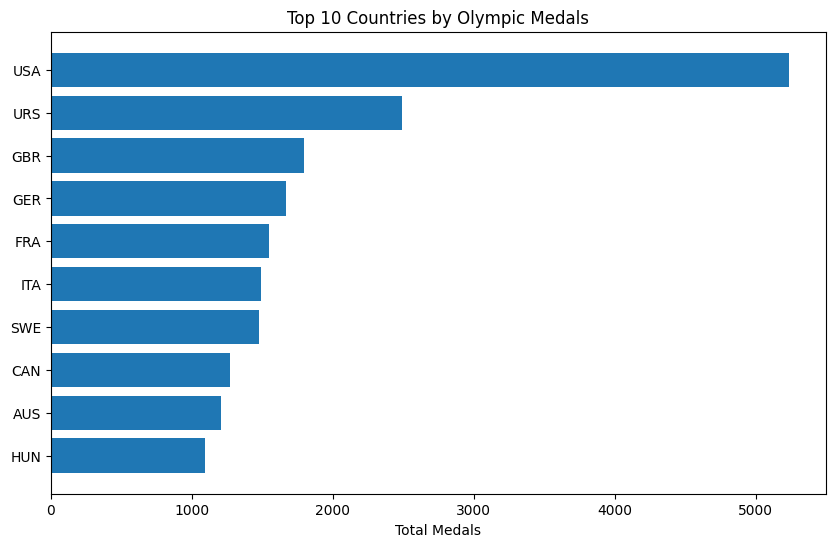

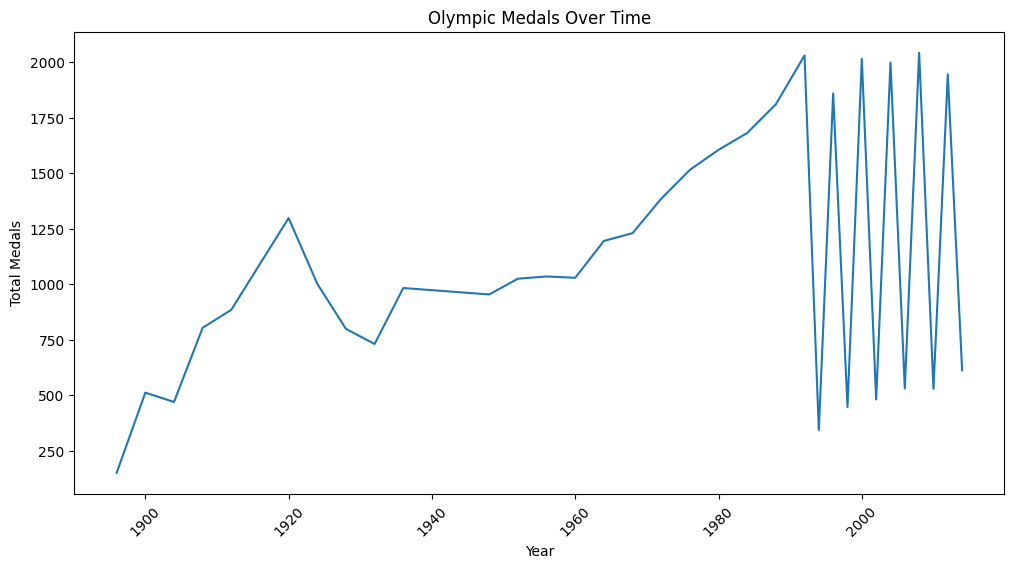

Project Summary:
- Total Olympic Records: 36935
- Unique Countries: 149
- Most Medals: USA with 5238 medals


In [35]:
# Convert top results to Pandas for plotting
top_countries_pd = medal_counts.limit(10).toPandas()

plt.figure(figsize=(10, 6))
plt.barh(top_countries_pd['Country'], top_countries_pd['TotalMedals'])
plt.xlabel('Total Medals')
plt.title('Top 10 Countries by Olympic Medals')
plt.gca().invert_yaxis()
plt.show()

# Yearly trend plot
yearly_pd = yearly_medals.toPandas()
plt.figure(figsize=(12, 6))
plt.plot(yearly_pd['YearInt'], yearly_pd['TotalMedals'])
plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.title('Olympic Medals Over Time')
plt.xticks(rotation=45)
plt.show()

# Summary report
print("Project Summary:")
print(f"- Total Olympic Records: {df_olympics.count()}")
print(f"- Unique Countries: {df_olympics.select('Country').distinct().count()}")
print(f"- Most Medals: {top_countries_pd.iloc[0]['Country']} with {top_countries_pd.iloc[0]['TotalMedals']} medals")